### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv
import sys
#sys.path.append('/content/KD')
# Import the module
import networks
import utils

%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [4]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student = 'checkpoints_student_QAT/'
if not os.path.exists(checkpoints_path_teacher):
    os.makedirs(checkpoints_path_teacher)
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)

### Load dataset

In [5]:
import torchvision
import torchvision.transforms as transforms
import PIL

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

import torchvision as tv
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
])

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
import torchvision
import torchvision.transforms as transforms

# Set up transformations for CIFAR-100
transform_train = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),  # Randomly crop with padding of 4 pixels
        transforms.RandomHorizontalFlip(),     # Random horizontal flip
        transforms.ToTensor(),                 # Convert to PyTorch tensor
        transforms.Normalize(
            (0.5071, 0.4867, 0.4408),         # Mean for CIFAR-100
            (0.2675, 0.2565, 0.2761)          # Standard deviation for CIFAR-100
        )  # Normalize images
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),                 # Convert to PyTorch tensor
        transforms.Normalize(
            (0.5071, 0.4867, 0.4408),         # Mean for CIFAR-100
            (0.2675, 0.2565, 0.2761)          # Standard deviation for CIFAR-100
        )  # Normalize images
    ]
)

# Load CIFAR-100 dataset
train_val_dataset = torchvision.datasets.CIFAR100(root='./CIFAR100_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR100(root='./CIFAR100_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 512
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Train teacher network

In [17]:
num_epochs = 100
print_every = 100    # Interval size for which to print statistics of training

In [18]:
# Define hyperparameter ranges
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-3]
momentums = [0.90]
dropout_probabilities = [(0.0, 0.0)]

# Prepare the list of hyperparameters
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'dropout_input': hparam_tuple[0][0],
        'dropout_hidden': hparam_tuple[0][1],
        'weight_decay': hparam_tuple[1],
        'lr_decay': hparam_tuple[2],
        'momentum': hparam_tuple[3],
        'lr': hparam_tuple[4]
    }
    hparams_list.append(hparam)

# Results dictionary
results = {}

# CSV file setup
csv_file = "checkpoints_teacher/results_teacher"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    teacher_net = networks.TeacherNetwork()
    teacher_net = teacher_net.to(fast_device)

    hparam_tuple = utils.hparamDictToTuple(hparam)
    results[hparam_tuple] = utils.trainTeacherOnHparam(teacher_net, hparam, num_epochs, train_val_loader, None, print_every=print_every, fast_device=fast_device)

    training_time = time.time() - start_time

    # Save model
    save_path = checkpoints_path_teacher + utils.hparamToString(hparam) + '_final.tar'
    torch.save({
        'results': results[hparam_tuple],
        'model_state_dict': teacher_net.state_dict(),
        'epoch': num_epochs
    }, save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'],
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001


c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

### load pre-trained teacher network

In [40]:
# Path to the saved model
teacher_path = "checkpoints_teacher/dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_final.tar"

# Initialize the network
teacher_net = networks.TeacherNetworkBiT()
teacher_net = teacher_net.to(fast_device)


# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

test accuracy:  0.9752


In [30]:
# Instantiate the teacher networks
teacher_net_1 = networks.TeacherNetwork50()
checkpoint = torch.load('resnet50_cifar10_pretrained.bin')


teacher_net_1.model.load_state_dict(checkpoint)
teacher_net_2 = networks.TeacherNetworkBiT()

# Create the ensemble model
teacher_net = networks.EnsembleModel(teacher_net_1, teacher_net_2)

# Move the ensemble model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_net = teacher_net.to(device)

reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, device)
print('test accuracy: ', test_accuracy)

c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\daniel\AppData\Local\Temp\ipykernel_15720\1847993978.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

test accuracy:  0.9616


In [46]:
teacher_net = networks.TeacherNetwork50()
checkpoint = torch.load('resnet50_cifar10_pretrained.bin')


teacher_net.model.load_state_dict(checkpoint)

teacher_net = teacher_net.to(fast_device)

C:\Users\daniel\AppData\Local\Temp\ipykernel_61408\1010970965.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('resnet50_cifar10_pretrained.bin')


### Student Network

#### Student Network (with training)

In [8]:
num_epochs = 200
print_every = 100

In [9]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)


In [10]:
count_parameters(teacher_net)

23520842

In [35]:
num_epochs = 400


# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [7]
alphas = [1.0]
learning_rates = [5e-4]
learning_rate_decays = [0.95]
weight_decays = [1e-4]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


checkpoints_path_student = 'student_teacher_learn_BiT_longer/'

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [0]

# CSV file setup
csv_file = checkpoints_path_student + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for pruning_factor in pruning_factors:
    for hparam in hparams_list:
        print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

        # Measure training time
        start_time = time.time()

        reproducibilitySeed()
        student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=False, fuse=False, qat=False, dif_arch=True)
        student_net.to(fast_device)
        hparam_tuple = utils.hparamDictToTuple(hparam)

        # Count parameters
        student_params_num = count_parameters(student_net)
        
        print(pruning_factor, student_params_num, count_parameters(teacher_net))
        results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparamMixup(
                teacher_net, student_net, hparam, num_epochs,
                train_loader, val_loader,
                print_every=print_every,
                fast_device=fast_device, quant=False, checkpoint_save_path= checkpoints_path_student, resume_checkpoint='student_BiT_no_QAT\T=5, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.0005, lr_decay=0.95, momentum=0.9, weight_decay=0.0001_checkpoint_epoch_50.tar'
            )

        training_time = time.time() - start_time

        # Final model save
        final_save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
        torch.save({
            'results': results_distill[(hparam_tuple, pruning_factor)],
            'model_state_dict': student_net.state_dict(),
            'epoch': num_epochs
        }, final_save_path)

        # Calculate test accuracy
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
        print('Test accuracy: ', test_accuracy)

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
                hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
                test_accuracy, training_time
            ])

print(f"Results saved to {csv_file}")


Training with hparamsT=7, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.0005, lr_decay=0.95, momentum=0.9, weight_decay=0.0001 and pruning factor 0
0 11173962 23520842
[Epoch 51, Batch 100/372] Train Loss: 0.173, Train Accuracy: 0.141
[Epoch 51, Batch 200/372] Train Loss: 0.318, Train Accuracy: 0.297
[Epoch 51, Batch 300/372] Train Loss: 0.142, Train Accuracy: 0.977
Epoch 51 Validation Accuracy: 0.938
[Epoch 52, Batch 100/372] Train Loss: 0.147, Train Accuracy: 0.984
[Epoch 52, Batch 200/372] Train Loss: 0.203, Train Accuracy: 0.117
[Epoch 52, Batch 300/372] Train Loss: 0.355, Train Accuracy: 0.297
Epoch 52 Validation Accuracy: 0.938
[Epoch 53, Batch 100/372] Train Loss: 0.167, Train Accuracy: 0.977
[Epoch 53, Batch 200/372] Train Loss: 0.233, Train Accuracy: 0.867
[Epoch 53, Batch 300/372] Train Loss: 0.195, Train Accuracy: 0.922
Epoch 53 Validation Accuracy: 0.937
[Epoch 54, Batch 100/372] Train Loss: 0.289, Train Accuracy: 0.531
[Epoch 54, Batch 200/372] Train Loss: 0.220, 

KeyboardInterrupt: 

In [ ]:
num_epochs = 400


# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [4]
alphas = [1.0]
learning_rates = [1e-3]
learning_rate_decays = [0.95]
weight_decays = [0.0]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []


checkpoints_path_student = 'student_resnet50_cosine_scheduler/'

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [0]

# CSV file setup
csv_file = checkpoints_path_student + "results_student.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for pruning_factor in pruning_factors:
    for hparam in hparams_list:
        print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

        # Measure training time
        start_time = time.time()

        reproducibilitySeed()
        student_net = networks.StudentNetwork(pruning_factor, teacher_net, q=True, fuse=True, qat=True, dif_arch=True)
        student_net.qconfig = torch.quantization.get_default_qat_qconfig('x86')
        prepared_student = torch.quantization.prepare_qat(student_net)
        prepared_student.to(fast_device)
        hparam_tuple = utils.hparamDictToTuple(hparam)

        # Count parameters
        student_params_num = count_parameters(prepared_student)
        
        print(pruning_factor, student_params_num, count_parameters(teacher_net))
        results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparamMixup(
                teacher_net, prepared_student, hparam, num_epochs,
                train_loader, val_loader,
                print_every=print_every,
                fast_device=fast_device, quant=True, checkpoint_save_path= checkpoints_path_student, resume_checkpoint='student_resnet50_cosine_scheduler\T=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0_checkpoint_epoch_200.tar',
                optimizer_choice='sgd'
            )

        training_time = time.time() - start_time
        prepared_student.to('cpu')
        prepared_student.eval()
        
        quantized_model = torch.quantization.convert(prepared_student)

        # Final model save
        final_save_path = checkpoints_path_student + utils.hparamToString(hparam) + '.tar'
        torch.save({
            'results': results_distill[(hparam_tuple, pruning_factor)],
            'model_state_dict': quantized_model.state_dict(),
            'epoch': num_epochs
        }, final_save_path)

        # Calculate test accuracy
        _, test_accuracy = utils.getLossAccuracyOnDataset(quantized_model, test_loader, 'cpu')
        print('Test accuracy: ', test_accuracy)

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
                hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
                test_accuracy, training_time
            ])

print(f"Results saved to {csv_file}")


Training with hparamsT=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.001, lr_decay=0.95, momentum=0.9, weight_decay=0.0 and pruning factor 0


c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\daniel\dsc180b\DSC180B_Q2_Project\utils.py:3

0 11173962 23520842
[Epoch 201, Batch 100/372] Train Loss: 1.751, Train Accuracy: 0.102
[Epoch 201, Batch 200/372] Train Loss: 2.935, Train Accuracy: 0.383


In [45]:
info = torch.load('checkpoints_student_QAT\T=10, alpha=0.5, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_pruning_0_final.tar')['results']

C:\Users\daniel\AppData\Local\Temp\ipykernel_46452\2442132776.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load('checkpoints_student_QAT\T=10, alpha=0.5,

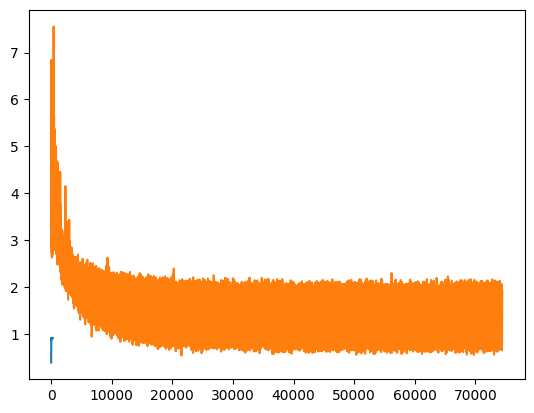

In [49]:
import matplotlib.pyplot as plt

plt.plot(info['val_acc'])
plt.plot(info['train_loss'])

#### Student Network (without training)

In [ ]:
# Define hyperparameter ranges
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-3]
momentums = [0.90]
dropout_probabilities = [(0.0, 0.0)]

# Prepare the list of hyperparameters
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'dropout_input': hparam_tuple[0][0],
        'dropout_hidden': hparam_tuple[0][1],
        'weight_decay': hparam_tuple[1],
        'lr_decay': hparam_tuple[2],
        'momentum': hparam_tuple[3],
        'lr': hparam_tuple[4]
    }
    hparams_list.append(hparam)

# Results dictionary
results = {}
pruning_factors = [i/20 for i in range(1, 20)]

# CSV file setup
csv_file = "checkpoints_student/results_student_wo.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Trainable Parameters", "Test Accuracy", "Training Time (s)"])

# Training and logging
for pruning_factor in pruning_factors:
    for hparam in hparams_list:
        print('Training without hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

        # Measure training time
        start_time = time.time()

        reproducibilitySeed()
        student_net_wo = networks.StudentNetwork(pruning_factor, teacher_net)
        student_net_wo = student_net_wo.to(fast_device)
        #hparam_tuple = utils.hparamDictToTuple(hparam)

        # Count parameters
        student_params_num = count_parameters(student_net_wo)
        print(pruning_factor, student_params_num, count_parameters(teacher_net))

        # Train the student network
        #results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs,
                                                                                    #train_val_loader, None,
                                                                                    #print_every=print_every,
                                                                                    #fast_device=fast_device)

        training_time = time.time() - start_time

        # Save model
        #save_path = checkpoints_path_student + utils.hparamToString(hparam) + f'_pruning_{pruning_factor}_w/o_final.tar'
        #torch.save({
            #'results': results_distill[(hparam_tuple, pruning_factor)],
            #'model_state_dict': student_net.state_dict(),
            #'epoch': num_epochs
        #}, save_path)

        # Calculate test accuracy
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_wo, test_loader, fast_device)
        print('Test accuracy: ', test_accuracy)

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
                hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
                test_accuracy, training_time
            ])

print(f"Results saved to {csv_file}")

Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.05


c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.05 10623029 11181642
Test accuracy:  0.8617
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.1
0.1 10064428 11181642
Test accuracy:  0.8622
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.15
0.15 9505825 11181642
Test accuracy:  0.862
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.2
0.2 8947224 11181642
Test accuracy:  0.8614
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.25
0.25 8388631 11181642
Test accuracy:  0.8595
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.3
0.3 7830025 11181642
Test accuracy:  0.8583
Training withou

In [ ]:
checkpoint = torch.load("your_checkpoint.tar")

_, test_accuracy = utils.getLossAccuracyOnDataset(test_model, test_loader, fast_device)
print('Test accuracy: ', test_accuracy)

In [ ]:
import pandas as pd
result = pd.DataFrame(columns=['Pruning Factor', 'Accuracy'])

In [ ]:
import torch
import itertools
import networks  # Ensure the correct import of your networks module
import utils  # Utilities for hyperparameter string conversion and more


# Define your hyperparameters
t = [10]
alpha = [0.5]
dropout_probabilities = [(0.0, 0.0)]
weight_decays = [1e-5]
learning_rate_decays = [0.95]
momentums = [0.9]
learning_rates = [1e-2]
pruning_factors = [i/32 for i in range(1, 33)]
#pruning_factors = [0.1, 0.2]  # Example pruning factors

hparams_list = []
for hparam_tuple in itertools.product(t, alpha, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'T': hparam_tuple[0],
        'alpha': hparam_tuple[1],
        'dropout_input': hparam_tuple[2][0],
        'dropout_hidden': hparam_tuple[2][1],
        'weight_decay': hparam_tuple[3],
        'lr_decay': hparam_tuple[4],
        'momentum': hparam_tuple[5],
        'lr': hparam_tuple[6]
    }
    hparams_list.append(hparam)

# Define the path to your checkpoints
checkpoints_path_student = "../content/checkpoints_student/"

# Load and set up each student model based on hyperparameters and pruning factor
for hparam in hparams_list:
    for prune_factor in pruning_factors:
        filename = utils.hparamToString(hparam) + f'_pruning_{prune_factor}_final.tar'
        load_path = checkpoints_path_student + filename

        # Load the student network
        student_net = networks.StudentNetwork(prune_amount=prune_factor)
        student_net.load_state_dict(torch.load(load_path, map_location=fast_device, weights_only=True)['model_state_dict'])
        student_net = student_net.to(fast_device)  # Move to the appropriate device, again adjust as needed

        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)

        # Create a new DataFrame from the data to be added
        new_data = pd.DataFrame({'Pruning Factor': [prune_factor], 'Accuracy': [test_accuracy]})
        # Use concat to add the new data to the existing DataFrame
        result = pd.concat([result, new_data], ignore_index=True)
        print('student test accuracy for ' + f'pruning factor = {prune_factor}:', test_accuracy)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result['Pruning Factor'], result['Accuracy'], marker='o')
plt.title('Accuracy vs Pruning Factor')
plt.xlabel('Pruning Factor')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


NameError: name 'result' is not defined

<Figure size 1000x600 with 0 Axes>

In [54]:
# Assuming teacher_net and student_net are instances of TeacherNetwork and StudentNetwork, respectively
teacher_net = networks.TeacherNetwork()
student_net = networks.StudentNetwork(0.2)

# Calculate and print the total number of parameters for both models
teacher_total_params = count_parameters(teacher_net)
student_total_params = count_parameters(student_net)

# Calculate and print the number of zero parameters for both models
teacher_zero_params = count_zero_parameters(teacher_net)
student_zero_params = count_zero_parameters(student_net)

print(f"Teacher Network: {teacher_total_params} total parameters, {teacher_zero_params} are zero.")
print(f"Student Network: {student_total_params} total parameters, {student_zero_params} are zero.")

# Optionally, calculate the percentage of zero parameters in each model
teacher_zero_percent = 100 * teacher_zero_params / teacher_total_params
student_zero_percent = 100 * student_zero_params / student_total_params

print(f"Percentage of zero parameters in Teacher Network: {teacher_zero_percent:.2f}%")
print(f"Percentage of zero parameters in Student Network: {student_zero_percent:.2f}%")

TypeError: StudentNetwork.__init__() missing 1 required positional argument: 'teacher_net'